In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!pip install category_encoders

In [ ]:
!pip install feature-engine

In [ ]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from category_encoders import HashingEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from feature_engine.encoding import CountFrequencyEncoder, MeanEncoder, RareLabelEncoder, OrdinalEncoder


In [ ]:
!pip install imbalanced-learn

In [ ]:
!pip uninstall scikit-learn --yes
!pip uninstall imblearn --yes
!pip install scikit-learn==1.2.2
!pip install imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

In [ ]:
data = pd.read_csv('fraud_test.csv')


In [ ]:
y = data["is_fraud"]
X = data.drop(['is_fraud'],axis=1)

In [ ]:
#Modify columns
X_used = X.drop(['Unnamed: 0','street','city','state','cc_num', 'unix_time', 'trans_num'], axis=1)
X_used[['date', 'time']] = X_used['trans_date_trans_time'].str.split(' ', expand=True)
X_used[['day', 'month', 'year']] = X_used['date'].str.split('/', expand=True)
X_used['time'] = X_used['time'].apply(lambda x: x.split(':')[0])
X_used['dob'] = X_used['dob'].apply(lambda x: x.split('/')[-1])
X_used["gender"] = X_used["gender"].replace({'M': 0, 'F': 1})
X_used = X_used.drop(['trans_date_trans_time','date'], axis=1)

<ipython-input-172-ee95265836cb>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_used["gender"] = X_used["gender"].replace({'M': 0, 'F': 1})


Using code from Kaggle to remove little siginificant features, split several features to make it more useful, and encode features into binary value: https://www.kaggle.com/code/ivetrano/credit-card-fraud-prediction-99-7-accuracy

In [ ]:
print(X_used)

In [ ]:
used_data = X_used.copy()
used_data['is_fraud'] = y

In [ ]:
print(used_data)

In [ ]:
#Find categorical features for future use
features = used_data.select_dtypes(np.object_).columns
cat_features = []
for feature in features:
    used_data[feature] = used_data[feature].astype('category')
    cat_features.append(feature)

In [ ]:
#split data into train and test and make sure the proportion of fraud and non_fraud data to be the same.
X_train, X_test, y_train, y_test = train_test_split(used_data.drop('is_fraud', axis = 1),
                                                    used_data['is_fraud'],
                                                    stratify = used_data['is_fraud'],
                                                    test_size = 0.25)

In [ ]:
train_data = X_train.copy()
train_data['is_fraud'] = y_train

<ipython-input-177-69342c6395cb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_fraud', data=train_data, palette=colors)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

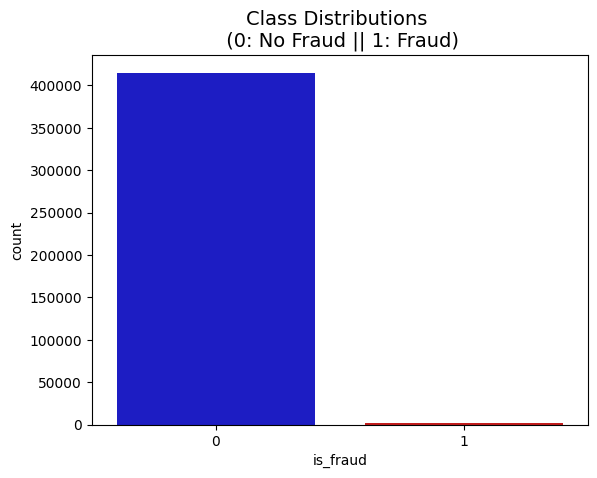

In [ ]:
#Show plot
import matplotlib.pyplot as plt
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='is_fraud', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

In [ ]:
print(train_data.dtypes)

In [ ]:
#Use target encoder to transform categorical features into numerical features
target_encoder = TargetEncoder()
train_data[cat_features] = target_encoder.fit_transform(train_data[cat_features], train_data["is_fraud"])

In [ ]:
train_data.head()

,merchant,category,amt,first,last,gender,zip,lat,long,city_pop,job,dob,merch_lat,merch_long,time,day,month,year,is_fraud
145087,6.548461e-14,0.002299,4.78,0.002077,0.004695,0,38922,33.9215,-89.6782,3451,0.000000,0.003051,33.481092,-90.185902,0.001042,0.002961,0.004501,0.00386,0
170193,5.347556e-13,0.002299,9.89,0.006217,0.000000,1,97403,44.0385,-123.0614,191096,0.000000,0.003590,43.538268,-123.808702,0.000888,0.003714,0.004501,0.00386,0
151602,1.510067e-02,0.012605,8.31,0.012146,0.000000,0,8323,39.4055,-75.3209,804,0.008000,0.004907,38.975611,-75.043001,0.009939,0.003690,0.004501,0.00386,0
360412,1.872075e-02,0.012605,120.85,0.007542,0.017028,1,95528,40.5070,-123.9743,1139,0.013289,0.003537,40.031560,-122.985230,0.000815,0.006229,0.004186,0.00386,0
367238,1.351351e-03,0.004146,8.04,0.007271,0.008130,1,76578,30.5920,-97.2893,1766,0.008130,0.003111,29.749916,-96.677254,0.000812,0.002961,0.004186,0.00386,0


In [ ]:
X_train = train_data.drop('is_fraud',axis=1)
y_train = train_data["is_fraud"]

In [ ]:
X_test[cat_features] = target_encoder.transform(X_test[cat_features])

In [ ]:
print(X_test)

        merchant  category     amt         first      last  gender    zip  \
66248   0.022444  0.009672  169.42  7.769145e-03  0.000000       1  98233   
450981  0.000000  0.001799   99.82  3.416467e-03  0.000000       1  28659   
526428  0.001626  0.001358  104.23  0.000000e+00  0.000562       1  26041   
51769   0.002778  0.001370   34.35  3.325272e-03  0.045714       1  39653   
459601  0.000000  0.001358    2.40  6.891271e-03  0.000000       0   4047   
...          ...       ...     ...           ...       ...     ...    ...   
540426  0.001527  0.001359    2.69  0.000000e+00  0.000000       1  13304   
192850  0.010782  0.009228  117.75  1.519757e-02  0.005160       1  64470   
450162  0.001946  0.002050    2.88  7.286164e-17  0.000000       1  13316   
303109  0.001626  0.001358   32.57  0.000000e+00  0.002199       1  92585   
170550  0.002601  0.004443   12.68  0.000000e+00  0.000000       1  48438   

            lat      long  city_pop       job       dob  merch_lat  \
66248

In [ ]:
#Undersampling by reducing size of non fraud_data to the size of fraud_data
def undersample(train_data):
  train_data = train_data.sample(frac=1)
  fraud_data = train_data.loc[train_data['is_fraud'] == 1]
  non_fraud_data = train_data.loc[train_data['is_fraud'] == 0][:1500]
  normal_distributed_data = pd.concat([fraud_data, non_fraud_data])
  new_data = normal_distributed_data.sample(frac=1, random_state=42)
  return new_data


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.3 MB/s eta 0:00:00


Below Tried to do catboost with undersampling but did not provide a good score. This pulled from the same kaggle code that is used for our oversampling method because it mentioned an undersamplign method. Undersampling just means its removes data points to make more balanced which leads to info loss

https://www.kaggle.com/code/eisgandar/oversampling-methods-on-unbalanced-datasets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc,roc_curve
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
#Run CatBoost
balanced_datas = []
y_predict_under = []
y_predict_proba_under = []
score = 0
roc_score = 0
pr_score = 0
#Create a set of 10 undersampled datasets
for i in range(10):
  balanced_datas.append(undersample(train_data))

from sklearn.model_selection import GridSearchCV

catboost_model = CatBoostClassifier(iterations=1000,
                                    learning_rate=0.1,
                                    depth=6,
                                    loss_function='Logloss',
                                    eval_metric='AUC',
                                    verbose=False)

#Find the best average of prc and roc among all undersampled datasets
for data in balanced_datas:
  X_tr_under = data.drop(columns=['is_fraud'])
  y_tr_under = data['is_fraud']
  catboost_model.fit(X_tr_under, y_tr_under)
  y_pred_proba = catboost_model.predict_proba(X_test)
  y_pred = catboost_model.predict(X_test)
  roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
  precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:,1])
  pr_auc = auc(recall, precision)
  if(score<roc_auc+pr_auc):
    score = roc_auc+pr_auc
    roc_score = roc_auc
    pr_score = pr_auc
    y_predict_under = y_pred
    y_predict_proba_under = y_pred_proba

print(f"roc_auc: {roc_score} pr_recall: {pr_score}")


roc_auc: 0.993493579007286 pr_recall: 0.7276506682613023


From here, I am gonna try to use a variety of oversampling methods using code from https://www.kaggle.com/code/eisgandar/oversampling-methods-on-unbalanced-datasets

A lot of these methods had the format for the code. We just had to implementment.

In [ ]:
ovs = RandomOverSampler(sampling_strategy = "auto", random_state = 11)
x_rovs, y_rovs = ovs.fit_resample(X_train, y_train)

catboost_model.fit(x_rovs, y_rovs)
y_pred_proba_ovs = catboost_model.predict_proba(X_test)
y_pred_ovs = catboost_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_ovs[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_ovs[:,1])
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

roc_auc: 0.9966118931693829 pr_recall: 0.8645316442315535


In [ ]:
smovs = SMOTE(sampling_strategy = "auto", random_state = 11, k_neighbors = 5, n_jobs = -1)
x_smote, y_smote = smovs.fit_resample(X_train, y_train)

catboost_model.fit(x_smote, y_smote)
y_pred_proba_smovs = catboost_model.predict_proba(X_test)
y_pred_smovs = catboost_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_smovs[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_smovs[:,1])
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


roc_auc: 0.9942669091641666 pr_recall: 0.8208712450190563


In [ ]:
border_smovs = BorderlineSMOTE()
x_border, y_border = border_smovs.fit_resample(X_train, y_train)

catboost_model.fit(x_border, y_border)
y_pred_proba_border = catboost_model.predict_proba(X_test)
y_pred_border = catboost_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_border[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_border[:,1])
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

roc_auc: 0.9924968168967727 pr_recall: 0.8037646768448392


In [ ]:
b_svm = SVMSMOTE()
x_svm, y_svm = b_svm.fit_resample(X_train, y_train)

catboost_model.fit(x_svm, y_svm)
y_pred_proba_svm = catboost_model.predict_proba(X_test)
y_pred_svm = catboost_model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_svm[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_svm[:,1])
pr_auc = auc(recall, precision)
print(f"roc_auc: {roc_auc} pr_recall: {pr_auc}")

roc_auc: 0.9949254092630623 pr_recall: 0.8233445730844456


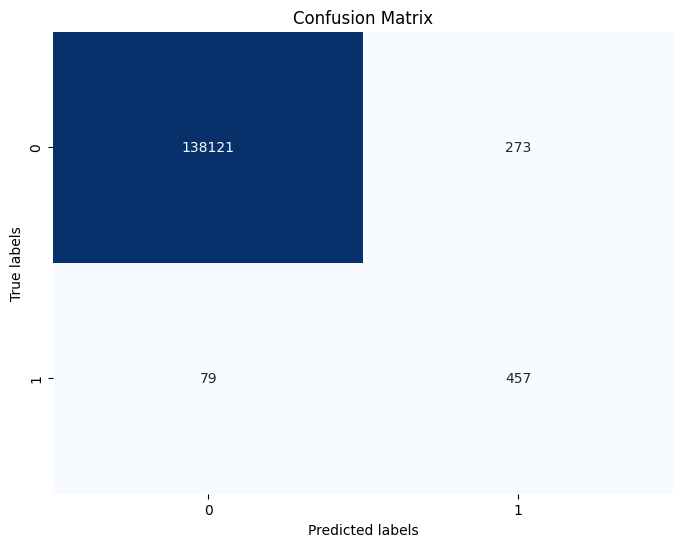

In [ ]:
cm = confusion_matrix(y_test, y_pred_ovs)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

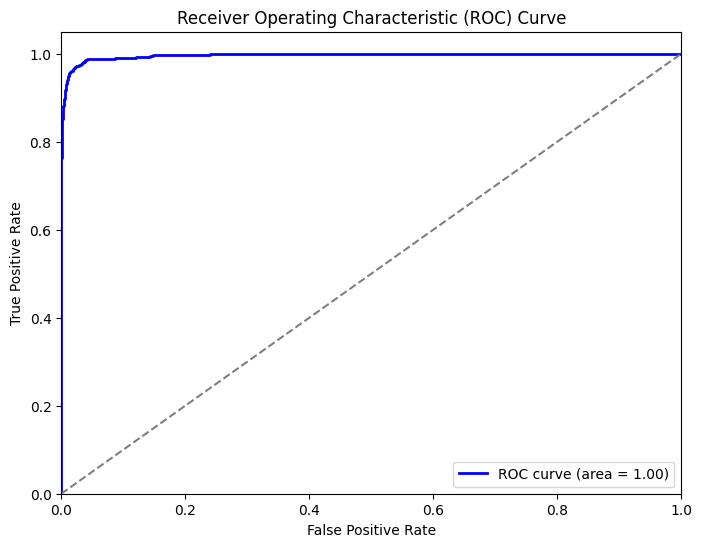

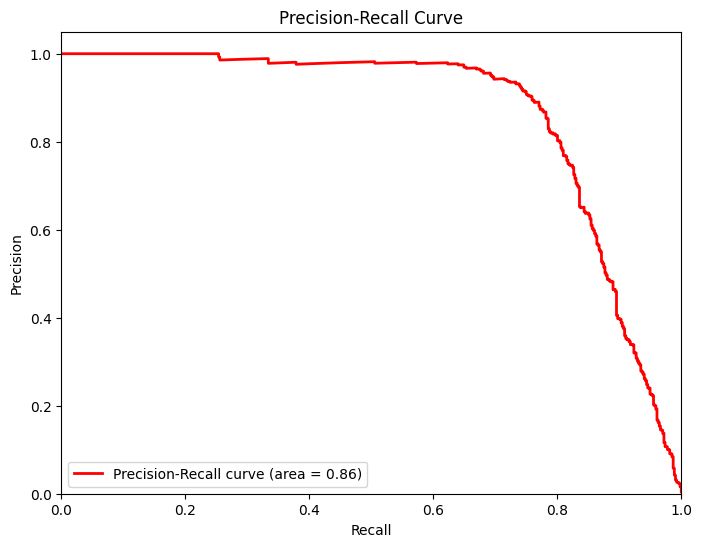

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_ovs[:,1])
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_ovs[:,1])
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='red', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.show()
